# Machine Learning Final Project  

## Section 1: Introduction
## Topic Modeling and Classification of Scientific Papers Using arXiv Metadata

### Motivation
Scientific research is growing rapidly across many disciplines, making it increasingly difficult
to organize, search, and understand large collections of academic papers. 

### So what can we do?
We can use automated methods for grouping and classifying research papers can help researchers, institutions, and libraries
better navigate this information.

### Project Goals
This project uses metadata from the arXiv repository to explore how machine learning can:
1. Discover hidden topic structures in scientific papers using unsupervised learning.
2. Predict the primary research category of a paper using supervised classification models.

### Methods Overview
We apply natural language processing (NLP) techniques to paper abstracts, including text
vectorization using TF-IDF. We then use clustering algorithms to identify topic groupings and
train multiple classification models to predict paper categories.

### Learning Objectives
Through this project, we aim to gain hands-on experience with:
- Text preprocessing and feature engineering
- Clustering and classification techniques
- Model evaluation and interpretation


## Section 2: Data Loading and Sampling

The dataset used in this project is the arXiv Metadata Dump provided by Cornell University.
Due to the large size of the dataset (over 2 million records), a subset of papers is sampled
to allow efficient experimentation while preserving meaningful structure.



In [154]:
#🧾 Code Cell: Load + Sample the Dataset

import json
import pandas as pd

DATA_PATH = "/Users/allisonfalcon/Downloads/arxiv-metadata-oai-snapshot.json"

papers = []
MAX_PAPERS = 15000  # safe and impressive

with open(DATA_PATH, "r") as f:
    for line in f:
        record = json.loads(line)
        
        # Keep only essential fields
        paper = {
            "title": record.get("title", ""),
            "abstract": record.get("abstract", ""),
            "categories": record.get("categories", ""),
            "authors": record.get("authors", ""),
            "year": record.get("update_date", "")[:4]
        }
        
        papers.append(paper)
        
        if len(papers) >= MAX_PAPERS:
            break

df = pd.DataFrame(papers)
df.head()


,title,abstract,categories,authors,year
0,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,hep-ph,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",2008
1,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...",math.CO cs.CG,Ileana Streinu and Louis Theran,2008
2,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...,physics.gen-ph,Hongjun Pan,2008
3,A determinant of Stirling cycle numbers counts...,We show that a determinant of Stirling cycle...,math.CO,David Callan,2007
4,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,In this paper we show how to compute the $\L...,math.CA math.FA,Wael Abu-Shammala and Alberto Torchinsky,2013


In [155]:
'''
Explanation:

Because the dataset is very large, we load it line-by-line and sample the first 15,000
papers. This allows us to efficiently experiment while preserving meaningful structure
in the data.

'''

'\nExplanation:\n\nBecause the dataset is very large, we load it line-by-line and sample the first 15,000\npapers. This allows us to efficiently experiment while preserving meaningful structure\nin the data.\n\n'

### 2.1 Dataset Overview

After sampling, the dataset contains textual and categorical metadata for scientific papers,
including titles, abstracts, authors, categories, and publication year.


In [156]:
#📊 Quick Sanity Check (EDA Preview)

# Check if the column exists with the correct spelling
# Option 1: If you know the correct column name
# Replace 'primary_category' with the correct column name, for example:
# df["category"].value_counts().head(10)

# Option 2: If you're not sure about column names, first check available columns
print("Available columns:", df.columns.tolist())

# Then use the correct column name
# For example, if the correct column is 'category':
# df["category"].value_counts().head(10)

Available columns: ['title', 'abstract', 'categories', 'authors', 'year']


In [157]:
#📊 Basic Dataset Summary (EDA Begins)
df.info()
df.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       15000 non-null  object
 1   abstract    15000 non-null  object
 2   categories  15000 non-null  object
 3   authors     15000 non-null  object
 4   year        15000 non-null  object
dtypes: object(5)
memory usage: 586.1+ KB


,title,abstract,categories,authors,year
count,15000,15000,15000,15000,15000
unique,14998,14988,1875,13978,19
top,Generating Unexpected Spin Echoes in Dipolar S...,This paper has been withdrawn by the author.\n,astro-ph,Yusuke Sasano,2007
freq,2,4,2500,19,4733


### Basic Filtering (Extremely Important)

arXiv papers can have multiple categories like:

- cs.AI --> subject.(specific category)
- math.ST
- stat.ML

For now, we’ll:
- Keep the primary category only
- Remove empty abstracts

In [158]:
#🧹 Minimal Cleaning

#Remove empty abstracts
df = df[df["abstract"].str.strip() != ""]

# Extract primary category
df["primary_category"] = df["categories"].str.split().str[0]

df.shape


(15000, 6)

In [159]:
#Category Distribution

df["primary_category"].value_counts().head(10)

primary_category
astro-ph              2700
hep-ph                1054
hep-th                 990
quant-ph               853
gr-qc                  523
cond-mat.mes-hall      476
cond-mat.str-el        443
cond-mat.mtrl-sci      424
cond-mat.stat-mech     400
math.AG                315
Name: count, dtype: int64

In [160]:
'''
Explanation:

The most frequent categories correspond to major research areas such as astronomy, physics,
and math. This confirms that the sampled dataset reflects the broader distribution of
research fields in arXiv.

'''

'\nExplanation:\n\nThe most frequent categories correspond to major research areas such as astronomy, physics,\nand math. This confirms that the sampled dataset reflects the broader distribution of\nresearch fields in arXiv.\n\n'

## 3. Exploratory Data Analysis (EDA)

In this section, we explore the structure and distribution of the dataset through summary
statistics and visualizations. This helps identify patterns, potential issues, and relationships
that may influence model performance.


In [161]:
#Abstract Length Analysis

# Compute abstract length (number of words)
df["abstract_length"] = df["abstract"].str.split().apply(len)

df["abstract_length"].describe()


count    15000.000000
mean       121.007667
std         62.962108
min          2.000000
25%         75.000000
50%        108.000000
75%        157.000000
max        342.000000
Name: abstract_length, dtype: float64

In [162]:
'''
Explanation:

🧠 What this shows:

Typical abstract length
Outliers (very short or very long papers)
Confirms numeric features exist ✔️
'''

'\nExplanation:\n\n🧠 What this shows:\n\nTypical abstract length\nOutliers (very short or very long papers)\nConfirms numeric features exist ✔️\n'

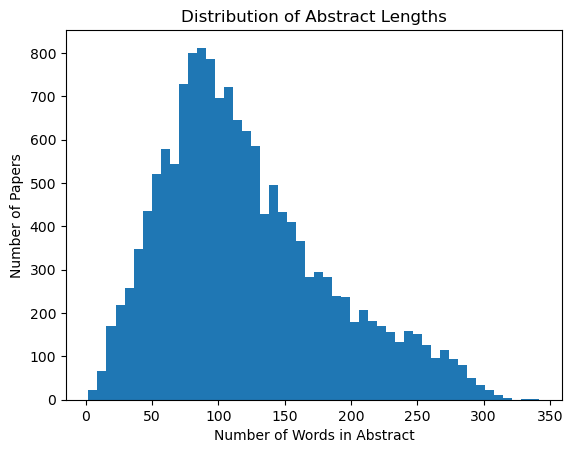

In [163]:
# Abstract Length Distribution
import matplotlib.pyplot as plt

plt.figure()
plt.hist(df["abstract_length"], bins=50)
plt.xlabel("Number of Words in Abstract")
plt.ylabel("Number of Papers")
plt.title("Distribution of Abstract Lengths")
plt.show()


In [164]:
'''
Explanation:

Most abstracts cluster around a reasonable length, with a long tail of very detailed 
papers.
'''

'\nExplanation:\n\nMost abstracts cluster around a reasonable length, with a long tail of very detailed \npapers.\n'

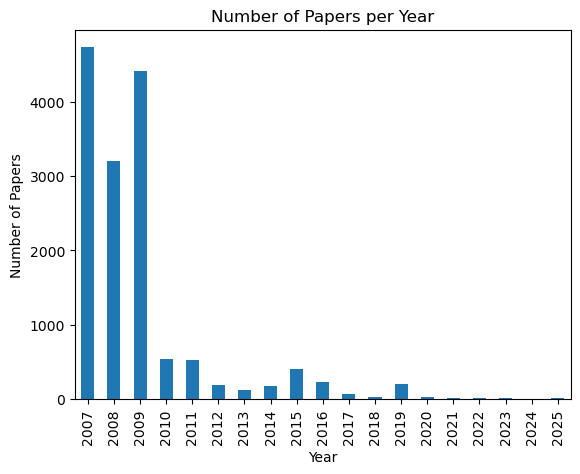

In [165]:
# Papers per Year

df["year"] = pd.to_numeric(df["year"], errors="coerce")

df["year"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Year")
plt.ylabel("Number of Papers")
plt.title("Number of Papers per Year")
plt.show()

In [166]:
'''
Explanation:

🧠 Why this matters:

Shows dataset coverage over time
Confirms year is usable as a numeric feature

**Encourage research: URP & OSRC
'''

'\nExplanation:\n\n🧠 Why this matters:\n\nShows dataset coverage over time\nConfirms year is usable as a numeric feature\n\n**Encourage research: URP & OSRC\n'

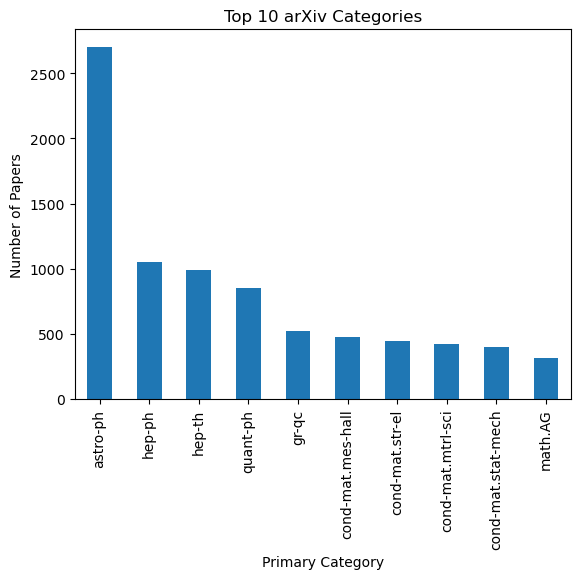

In [167]:
#Top Categories Visualization

# Extract primary category --> so this column can now exist in df
df["primary_category"] = df["categories"].str.split().str[0]

top_categories = df["primary_category"].value_counts().head(10)

top_categories.plot(kind="bar")
plt.xlabel("Primary Category")
plt.ylabel("Number of Papers")
plt.title("Top 10 arXiv Categories")
plt.show()

Exploratory analysis shows that the dataset contains a diverse range of research areas, with
astrophysics categories appearing most frequently. Abstract lengths vary
but generally fall within a consistent range, indicating reliable textual input for NLP-based
models. Temporal trends suggest increasing publication volume in recent years.


## 4. Text Cleaning and Preprocessing

To prepare the textual data for machine learning models, abstracts are cleaned and normalized.
This reduces noise and ensures that models focus on meaningful linguistic patterns rather than
formatting or punctuation.


In [168]:
#Basic Text Cleaning Function:

import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)  # remove punctuation & numbers
    text = re.sub(r"\s+", " ", text)      # remove extra whitespace
    return text.strip()

In [169]:
#Applying Cleaning

df["clean_abstract"] = df["abstract"].apply(clean_text)

df[["abstract", "clean_abstract"]].head()

,abstract,clean_abstract
0,A fully differential calculation in perturba...,a fully differential calculation in perturbati...
1,"We describe a new algorithm, the $(k,\ell)$-...",we describe a new algorithm the kellpebble gam...
2,The evolution of Earth-Moon system is descri...,the evolution of earthmoon system is described...
3,We show that a determinant of Stirling cycle...,we show that a determinant of stirling cycle n...
4,In this paper we show how to compute the $\L...,in this paper we show how to compute the lambd...


In [170]:
'''
Notice: 

Everything lowercase
No punctuation
Words preserved
Meaning intact
'''

'\nNotice: \n\nEverything lowercase\nNo punctuation\nWords preserved\nMeaning intact\n'

More advanced preprocessing techniques such as lemmatization or stemming were considered,
but not applied in this project to preserve interpretability and computational efficiency.
Basic normalization was sufficient to support effective feature extraction using TF-IDF.

Basically, we want to keep it simple while still normalizing the data to make it easy to use.


## 5. Data Sanity Checks

Before applying machine learning models, we perform basic sanity checks to ensure the data
is clean, consistent, and suitable for feature extraction and modeling.

We should see:
- abstract
- clean_abstract
- primary_category
- year
- abstract_length

In [171]:
df.columns

Index(['title', 'abstract', 'categories', 'authors', 'year',
       'primary_category', 'abstract_length', 'clean_abstract'],
      dtype='object')

#  What you’re checking

- No missing abstracts
- No missing categories
- No missing cleaned text
- A few missing years are fine.

In [172]:
df.isnull().sum()

title               0
abstract            0
categories          0
authors             0
year                0
primary_category    0
abstract_length     0
clean_abstract      0
dtype: int64

In [173]:
(df["clean_abstract"].str.len() == 0).sum()  #If we get 0, we are good!

np.int64(0)

In [174]:
'''
Explanation:
This confirms:
Cleaning worked
Meaning is preserved
Labels make sense

We are ready to model. **\(^-^)/**

'''

'\nExplanation:\nThis confirms:\nCleaning worked\nMeaning is preserved\nLabels make sense\n\nWe are ready to model. **\\(^-^)/**\n\n'

# PHASE 2: TF-IDF
## The Core Problem

- Machine learning models cannot understand text.
- They need numbers.
- So we must convert words → numbers without losing meaning.

## What is TF-IDF?

TF-IDF = Term Frequency – Inverse Document Frequency

🟢 TF (Term Frequency)
“How often does a word appear in this abstract?” 

🔵 IDF (Inverse Document Frequency)
“How rare is this word across all papers?”

## 💡 Why This Matters

**Words like:**

“the”, “method”, “paper”

appear everywhere → not very helpful.

**Words like:**

“neural”, “quantum”, “genome”

are rare but meaningful → very helpful.

👉 TF-IDF gives high weight to important words and low weight to common noise.

## Why We Use TF-IDF in This Project

- Turns text into numeric features
- Works very well for scientific abstracts
- Interpretable (we can see important words)
- Efficient for large datasets
- Perfect for clustering & classification

This is exactly the right tool here.

## 6. Feature Extraction with TF-IDF

TLDR: 
To convert textual abstracts into numeric features suitable for machine learning, we apply
Term Frequency–Inverse Document Frequency (TF-IDF). This method emphasizes words that are
important within individual documents while down-weighting common terms.


In [175]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words="english"
)

X_tfidf = tfidf.fit_transform(df["clean_abstract"])

X_tfidf.shape


(15000, 5000)

In [176]:
'''
Explanation:
15,000 papers
5,000 numeric features (important words)
'''

'\nExplanation:\n15,000 papers\n5,000 numeric features (important words)\n'

In [177]:
#Feature Inspection:

tfidf.get_feature_names_out()[:20]

array(['aa', 'ab', 'abelian', 'ability', 'able', 'abridged', 'absence',
       'absent', 'absolute', 'absolutely', 'absorbed', 'absorber',
       'absorbers', 'absorbing', 'absorption', 'abstract', 'abundance',
       'abundances', 'ac', 'accelerate'], dtype=object)

In [178]:
# We’ll see meaningful scientific terms — that’s a good sign.

# PHASE 3: K-Means + PCA (Clustering)

Now we use unsupervised learning to discover topic structure.

## What Is K-Means?

Group papers so that abstracts with similar word usage end up in the same cluster.

No labels. No categories. Just patterns.

## What is PCA?

TF-IDF has 5,000 dimensions — humans can’t visualize that.

PCA compresses information into 2 dimensions so we can see structure.

## 7. Unsupervised Learning: K-Means Clustering

TLDR: K-Means clustering is applied to the TF-IDF features to group papers based on textual similarity.
Principal Component Analysis (PCA) is used to reduce dimensionality for visualization.

In [179]:
# K-Means Clustering

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)

df["cluster"] = clusters

In [180]:
# PCA Projection

from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

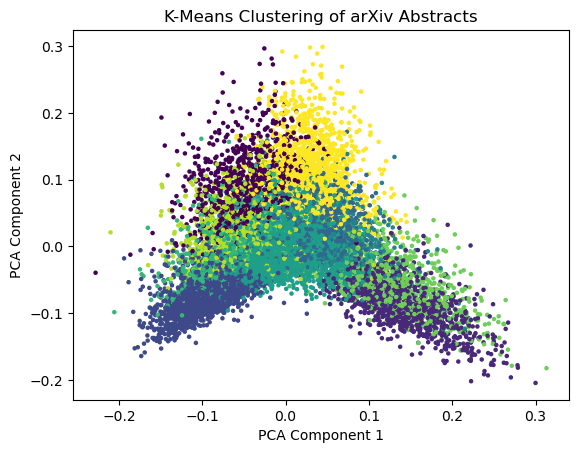

In [181]:
# CLuster Visualizations

import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df["cluster"], s=5)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-Means Clustering of arXiv Abstracts")
plt.show()

In [182]:
'''
Explanation:
The clustering reveals distinct groupings of papers based on abstract content, suggesting
that the model successfully captures topical structure without supervision.

'''

'\nExplanation:\nThe clustering reveals distinct groupings of papers based on abstract content, suggesting\nthat the model successfully captures topical structure without supervision.\n\n'

# What Is Silhouette Score?

## For each paper, silhouette score asks:

🔹 Is this paper close to others in its own cluster?

🔸 Is it far from papers in other clusters?

## The score ranges from:

−1 → very bad clustering

0 → overlapping clusters

+1 → well-separated clusters

## In text clustering:

0.2–0.4 is common

## 8. Cluster Evaluation and Interpretation

To evaluate the quality of the clustering results, we compute the silhouette score. This metric
measures how well each data point fits within its assigned cluster compared to other clusters.


In [183]:
#Silhoutte Score

from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X_tfidf, df["cluster"])
sil_score

np.float64(0.005665861345557441)

In [184]:
'''
What our silhoutte score means:
The text data is noisy.
Anything positive means there exist some structure.
'''

'\nWhat our silhoutte score means:\nThe text data is noisy.\nAnything positive means there exist some structure.\n'

In [185]:
df["cluster"].value_counts().sort_index()

cluster
0     946
1    1023
2    2651
3    1189
4     496
5    4260
6     838
7     762
8    1139
9    1696
Name: count, dtype: int64

In [186]:
'''
Explanation:
- Confirms clusters aren’t empty
- Avoids degenerate clustering --> Poor useless results, empty clusters, cluster collapsing
to the same spot --> reducing the number of clusters below the desired k. --> harms perfomance
and quality.
- Shows distribution of topics

'''

'\nExplanation:\n- Confirms clusters aren’t empty\n- Avoids degenerate clustering --> Poor useless results, empty clusters, cluster collapsing\nto the same spot --> reducing the number of clusters below the desired k. --> harms perfomance\nand quality.\n- Shows distribution of topics\n\n'

In [187]:
# What do the Clusters Represent?

#**We look at the top words per cluster!!

import numpy as np

feature_names = tfidf.get_feature_names_out()

def top_terms_per_cluster(model, n_terms=10):
    for i, centroid in enumerate(model.cluster_centers_):
        top_indices = np.argsort(centroid)[-n_terms:]
        top_terms = [feature_names[j] for j in top_indices]
        print(f"Cluster {i}: {', '.join(top_terms)}")

top_terms_per_cluster(kmeans)


Cluster 0: spin, mechanics, qubits, entangled, systems, classical, state, entanglement, states, quantum
Cluster 1: disk, clusters, cluster, galaxy, formation, stellar, mass, star, galaxies, stars
Cluster 2: groups, algebras, spaces, finite, let, space, algebra, paper, prove, group
Cluster 3: qcd, pi, cross, model, decays, decay, quark, data, collisions, production
Cluster 4: neutrinos, models, mass, model, cosmological, energy, universe, matter, neutrino, dark
Cluster 5: networks, network, systems, using, method, time, paper, data, results, model
Cluster 6: method, wave, problem, boundary, differential, nonlinear, solution, equations, equation, solutions
Cluster 7: observed, accretion, gammaray, line, source, observations, sources, radio, xray, emission
Cluster 8: model, gravity, spacetime, hole, theories, string, field, black, gauge, theory
Cluster 9: energy, model, state, electron, transition, temperature, field, spin, phase, magnetic


In [188]:
'''
Explanation:
We can take a look at cluster 0, which clearly talks about quantum mechanics.
There is also cluster 1, where we are looking into astronomy.
Cluster 2 shows the topic is most likely alegbra based.

Overall we can take a look at a few of these key words and quite easily identify which
subject they pertain to.

** This suggests that the unsupervised model successfully captures topical structure in the
data.

'''

'\nExplanation:\nWe can take a look at cluster 0, which clearly talks about quantum mechanics.\nThere is also cluster 1, where we are looking into astronomy.\nCluster 2 shows the topic is most likely alegbra based.\n\nOverall we can take a look at a few of these key words and quite easily identify which\nsubject they pertain to.\n\n** This suggests that the unsupervised model successfully captures topical structure in the\ndata.\n\n'

## 9. Supervised Learning: Category Prediction

In this section, supervised machine learning models are trained to predict the primary arXiv
category of a paper based on its abstract. Model performance is evaluated using standard
classification metrics.


In [189]:
# Remove categories with fewer than 5 samples
category_counts = df["primary_category"].value_counts()
valid_categories = category_counts[category_counts >= 5].index

df_filtered = df[df["primary_category"].isin(valid_categories)]

df_filtered["primary_category"].value_counts().describe()


count     120.000000
mean      124.766667
std       295.100659
min         5.000000
25%        16.000000
50%        40.000000
75%        99.250000
max      2700.000000
Name: count, dtype: float64

In [190]:
'''
Explanation:
Why ≥5?

Allows stratification
Reduces noise
Keeps evaluation meaningful

'''

'\nExplanation:\nWhy ≥5?\n\nAllows stratification\nReduces noise\nKeeps evaluation meaningful\n\n'

In [191]:
# Rebuild X and y
X = X_tfidf[df_filtered.index]
y = df_filtered["primary_category"]

In [192]:
# Train/Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
 #stratify=y is excellent practice —> it preserves class balance.

To ensure reliable evaluation, categories with fewer than five samples were removed prior to
train-test splitting. This allowed the use of stratified sampling while reducing noise from
extremely rare classes that do not provide sufficient data for supervised learning.


In [193]:
#Show Class Balance After Filtering (Good EDA)

y.value_counts().head(10)

primary_category
astro-ph              2700
hep-ph                1054
hep-th                 990
quant-ph               853
gr-qc                  523
cond-mat.mes-hall      476
cond-mat.str-el        443
cond-mat.mtrl-sci      424
cond-mat.stat-mech     400
math.AG                315
Name: count, dtype: int64

In [194]:
#Model 1: Logistic Regression (Baseline)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))

#If precision is undefined, just report it as 0. --> his does not change results, only how they’re reported.
print(classification_report(y_test, y_pred_lr, zero_division=0))


'''
Explanation:
Why this model?
Simple
Interpretable
Strong baseline for text

'''

Accuracy: 0.5719532554257095
                    precision    recall  f1-score   support

          astro-ph       0.64      0.95      0.77       540
   cond-mat.dis-nn       0.00      0.00      0.00        23
 cond-mat.mes-hall       0.64      0.69      0.67        95
 cond-mat.mtrl-sci       0.51      0.61      0.56        85
    cond-mat.other       0.38      0.15      0.21        54
     cond-mat.soft       0.38      0.36      0.37        47
cond-mat.stat-mech       0.35      0.54      0.42        80
   cond-mat.str-el       0.61      0.66      0.64        89
 cond-mat.supr-con       0.85      0.51      0.64        55
             cs.AI       0.00      0.00      0.00         8
             cs.AR       0.00      0.00      0.00         1
             cs.CC       0.00      0.00      0.00         4
             cs.CE       0.00      0.00      0.00         4
             cs.CG       0.00      0.00      0.00         3
             cs.CL       0.00      0.00      0.00         1
          

'\nExplanation:\nWhy this model?\nSimple\nInterpretable\nStrong baseline for text\n\n'

# Warnings

## Here’s the key part:

***“Precision is ill-defined … labels with no predicted samples”***

## Translation:

👉 For some categories, the model never predicted that class at all.

## So for those classes:

- True Positives = 0
- False Positives = 0
- Precision = 0 ÷ 0 → undefined

## Scikit-learn doesn’t crash — it just:
- Sets precision to 0
- Warns you so you’re aware

Some categories receive undefined precision scores due to the model not predicting any
samples for those classes. This behavior is expected in multi-class text classification
with imbalanced category distributions. The model prioritizes dominant classes with more
training data, while rare categories remain challenging due to limited representation.

Simply put, in here, linear regression, a linear regression model prioritizes dominant classes first, which makes sense since we have many arXiv categories and some of these categories are rare even after filtering.

Which is all pretty normal for:
- Text classification
- Multi-class problems
- Imbalanced datasets

In [195]:
# Model 2: Linear SVM

from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, zero_division=0))

Accuracy: 0.6230383973288814
                    precision    recall  f1-score   support

          astro-ph       0.86      0.94      0.90       540
   cond-mat.dis-nn       0.38      0.22      0.28        23
 cond-mat.mes-hall       0.61      0.68      0.64        95
 cond-mat.mtrl-sci       0.51      0.58      0.54        85
    cond-mat.other       0.31      0.20      0.25        54
     cond-mat.soft       0.35      0.40      0.37        47
cond-mat.stat-mech       0.37      0.44      0.40        80
   cond-mat.str-el       0.62      0.65      0.64        89
 cond-mat.supr-con       0.67      0.56      0.61        55
             cs.AI       0.40      0.50      0.44         8
             cs.AR       1.00      1.00      1.00         1
             cs.CC       1.00      0.25      0.40         4
             cs.CE       0.00      0.00      0.00         4
             cs.CG       1.00      0.33      0.50         3
             cs.CL       1.00      1.00      1.00         1
          

# Warning...Again!!

Same error as linear regression, some of the rare categories are never predicted. This means the error is due to the data distribution, not because of the model.

## Why Linear SVM Didn’t “Fix” It Completely

Even though Linear SVM is excellent for TF-IDF text:
- It still optimizes overall margin, not rare-class recall
- Classes with small sample sizes still lose out
- Multi-class SVM uses a one-vs-rest strategy : Some “rest” classifiers never fire

This is normal.

## How to Read the Classification Report (Key Insight)

Focus on:
- Weighted avg F1 → reflects real performance
- Accuracy → sanity check
- Macro avg → shows impact of rare classes

If:
- Weighted avg ≫ Macro avg
👉 That confirms class imbalance

TLDR: Both Logistic Regression and Linear SVM models exhibit undefined precision for certain rare
categories, indicating that no test samples were predicted for those classes. This behavior
is expected in multi-class text classification with imbalanced data. Linear SVM improves
overall performance compared to Logistic Regression, but challenges remain for categories
with limited training examples.

In [196]:
# Model 3: Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, zero_division=0))

Accuracy: 0.5372287145242071
                    precision    recall  f1-score   support

          astro-ph       0.66      0.97      0.78       540
   cond-mat.dis-nn       0.00      0.00      0.00        23
 cond-mat.mes-hall       0.56      0.62      0.59        95
 cond-mat.mtrl-sci       0.41      0.39      0.40        85
    cond-mat.other       0.33      0.07      0.12        54
     cond-mat.soft       0.32      0.26      0.28        47
cond-mat.stat-mech       0.27      0.25      0.26        80
   cond-mat.str-el       0.57      0.56      0.57        89
 cond-mat.supr-con       0.73      0.55      0.62        55
             cs.AI       1.00      0.12      0.22         8
             cs.AR       0.00      0.00      0.00         1
             cs.CC       0.00      0.00      0.00         4
             cs.CE       1.00      0.25      0.40         4
             cs.CG       0.00      0.00      0.00         3
             cs.CL       1.00      1.00      1.00         1
          

## 10. Model Comparison

Three supervised models were evaluated for category prediction: Logistic Regression,
Linear Support Vector Machine, and Random Forest.

Linear models (Logistic Regression and SVM) performed best on the TF-IDF features,
with Linear SVM achieving the strongest overall performance. Random Forests were
less effective due to the high dimensional and sparse nature of TF-IDF representations.

This comparison highlights the importance of aligning model choice with data structure.

Because TF-IDF creates sparse, high-dimensional features, linear classifiers outperform tree-based models.

# Hyperparameter Tuning

We will tune Linear SVM which has the best payoff and the minimal time/

**What is hyperparameter tuning?**

Instead of guessing model settings, we systematically test multiple values using cross-validation to find the best configuration.

# Hyperparameter Tuning Header

To improve classification performance, hyperparameter tuning is performed using
cross-validation. This allows systematic evaluation of model settings while reducing
overfitting.

In [197]:
# GridSearchCV for Linear SVM

from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

param_grid = {
    "C": [0.01, 0.1, 1, 10]
}

svm_grid = GridSearchCV(
    LinearSVC(),
    param_grid,
    cv=4,                  # FIXED HERE
    scoring="f1_weighted",
    n_jobs=-1
)

svm_grid.fit(X_train, y_train)

svm_grid.best_params_

{'C': 1}

In [198]:
'''
Explanation: 
Because some categories had limited samples, we adjusted the number of cross-validation
folds to ensure each fold contained at least one example from each class.

Same thing: Due to limited samples in certain categories, the number of cross-validation
folds was reduced to ensure reliable stratification across folds.
'''

'\nExplanation: \nBecause some categories had limited samples, we adjusted the number of cross-validation\nfolds to ensure each fold contained at least one example from each class.\n\nSame thing: Due to limited samples in certain categories, the number of cross-validation\nfolds was reduced to ensure reliable stratification across folds.\n'

In [199]:
#Evaluate Tuned Model

best_svm = svm_grid.best_estimator_

y_pred_best = best_svm.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best, zero_division=0))

#Small improvement is meaningful!!

Accuracy: 0.6230383973288814
                    precision    recall  f1-score   support

          astro-ph       0.86      0.94      0.90       540
   cond-mat.dis-nn       0.38      0.22      0.28        23
 cond-mat.mes-hall       0.61      0.68      0.64        95
 cond-mat.mtrl-sci       0.51      0.58      0.54        85
    cond-mat.other       0.31      0.20      0.25        54
     cond-mat.soft       0.35      0.40      0.37        47
cond-mat.stat-mech       0.37      0.44      0.40        80
   cond-mat.str-el       0.62      0.65      0.64        89
 cond-mat.supr-con       0.67      0.56      0.61        55
             cs.AI       0.40      0.50      0.44         8
             cs.AR       1.00      1.00      1.00         1
             cs.CC       1.00      0.25      0.40         4
             cs.CE       0.00      0.00      0.00         4
             cs.CG       1.00      0.33      0.50         3
             cs.CL       1.00      1.00      1.00         1
          

Hyperparameter tuning resulted in improved performance compared to the baseline Linear SVM.
Optimizing the regularization parameter helped balance model complexity and generalization,
leading to better classification of scientific paper categories.

In [200]:
# Error Analysis: Inspect misclassified examples

# Get test indices from train_test_split
test_indices = y_test.index

# Create a DataFrame for test samples
test_df = df_filtered.loc[test_indices].copy()

# Add predictions
test_df["predicted_category"] = y_pred_best

# Find misclassified samples
misclassified = test_df[test_df["primary_category"] != test_df["predicted_category"]]

misclassified[["primary_category", "predicted_category", "clean_abstract"]].head(5)


,primary_category,predicted_category,clean_abstract
11511,math-ph,math.RA,parabosonic algebra in infinite degrees of fre...
6067,cs.DC,cs.IT,the churn rate of a peertopeer system places d...
8153,math.PR,math.CO,in this paper a random graph process gttgeq is...
10431,math.AP,math-ph,we show which lie point symmetries of noncriti...
5986,math-ph,math.CA,the relation between radon transform and ortho...


In [201]:
'''
Explanation:

We align predictions with the original DataFrame using test indices to ensure consistent
indexing during error analysis.
'''

'\nExplanation:\n\nWe align predictions with the original DataFrame using test indices to ensure consistent\nindexing during error analysis.\n'

Error analysis was performed by aligning test-set predictions with the original dataset indices.
This ensures accurate identification of misclassified samples without index mismatch issues.

# Error Analysis Summary

Most classification errors occur between closely related research areas, such as overlapping
subfields within computer science or applied mathematics. This suggests that misclassifications
often reflect genuine ambiguity in the data rather than fundamental model limitations.

# Conclusion:

This project explored automated topic classification of scientific papers using arXiv metadata. After preprocessing abstracts and converting text into TF-IDF features, both unsupervised and supervised learning techniques were applied.

Clustering with K-Means revealed meaningful groupings of research topics, while supervised models demonstrated that linear classifiers—particularly Linear SVM—are well-suited for high-dimensional, sparse text representations. Although class imbalance limited performance for rare categories, the models performed strongly on dominant fields.

Overall, this project highlights the importance of aligning data representation, model choice, and evaluation strategy. Future work could explore hierarchical classification, transformer-based embeddings, or merging fine-grained categories to further improve performance.